In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score

import warnings
# Отключение предупреждений
warnings.filterwarnings('ignore')

/kaggle/input/cartoon/sample_submission.csv
/kaggle/input/cartoon/train.csv
/kaggle/input/cartoon/test.csv


### Классификация анимационных проектов

**Определение принадлежности видеороликов к проектам на основе анализа текстового описания, субтитров и другой доступной информации**

***Данные***

**Основное** 
- yt_reel_id уникальный идентификатор ролика
- cartoon целевая переменная

**Файлы**
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Колонки**
- date дата, когда ролик появился на ютубе
- reel_name название ролика
- yt_reel_id уникальный идентификатор ролика на ютубе
- cartoon название проекта, целевая переменная
- url ссылка на ролик (включает идентификатор)
- text текст сниппета, включает название ролика и описание
- seconds длительность
- is_shorts вертикальные видеоролики продолжительностью <60сек
- broadcast лайвы, прямые эфиры
- yt_channel_id идентификатор ютуб канала
- yt_channel_name название ютуб канала
- yt_ch_url ссылка на ютуб канал
- yt_channel_type тип канала (Мультфильмы, Детские, Блогеры, Shorts…)
- flag_closed ютуб канал закрыт, если 1
- international метка международных каналов, каналов на иностранном языке (переведенный - контент)
- language язык

### Загрузка данных

In [2]:
sample = pd.read_csv('/kaggle/input/cartoon/sample_submission.csv')
data = pd.read_csv('/kaggle/input/cartoon/train.csv', lineterminator='\n')
test_data = pd.read_csv('/kaggle/input/cartoon/test.csv', lineterminator='\n')

#### Посмотрим датасеты

In [3]:
def discover(data):
    display(data.info())
    display(f'Размер данных:{data.shape}') 
    display(f'Количество пропусков:{data.isna().sum()}')
    display(f'Количество дубликатов:{data.duplicated().sum()}') 
    display(data.head())

In [4]:
discover(sample) #формат рабочего решения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yt_reel_id  55608 non-null  object
 1   cartoon     55608 non-null  object
dtypes: object(2)
memory usage: 869.0+ KB


None

'Размер данных:(55608, 2)'

'Количество пропусков:yt_reel_id    0\ncartoon       0\ndtype: int64'

'Количество дубликатов:0'

,yt_reel_id,cartoon
0,RBw4j0aMWyM,Бегемотик
1,5wTfpmlZe5k,Космохомяк
2,Fd9YA-oDjSo,Улитка
3,NXCHY_J-5v0,Космохомяк
4,XM-GRekoYzs,Космохомяк


#### Тестовая выборка

In [5]:
discover(test_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55608 entries, 0 to 55607
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             55608 non-null  object 
 1   reel_name        55605 non-null  object 
 2   yt_reel_id       55608 non-null  object 
 3   url              55608 non-null  object 
 4   text             55608 non-null  object 
 5   seconds          49807 non-null  float64
 6   is_shorts        49807 non-null  float64
 7   broadcast        49807 non-null  object 
 8   yt_channel_id    55584 non-null  object 
 9   yt_channel_name  55580 non-null  object 
 10  yt_ch_url        55580 non-null  object 
 11  yt_channel_type  55580 non-null  object 
 12  flag_closed      55580 non-null  float64
 13  international    55580 non-null  float64
 14  language         337 non-null    object 
dtypes: float64(4), object(11)
memory usage: 6.4+ MB


None

'Размер данных:(55608, 15)'

'Количество пропусков:date                   0\nreel_name              3\nyt_reel_id             0\nurl                    0\ntext                   0\nseconds             5801\nis_shorts           5801\nbroadcast           5801\nyt_channel_id         24\nyt_channel_name       28\nyt_ch_url             28\nyt_channel_type       28\nflag_closed           28\ninternational         28\nlanguage           55271\ndtype: int64'

'Количество дубликатов:0'

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN


#### Тренировочная выборка

In [6]:
discover(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


None

'Размер данных:(83411, 16)'

'Количество пропусков:date                   0\nreel_name              3\nyt_reel_id             0\ncartoon                0\nurl                    0\ntext                   0\nseconds             8758\nis_shorts           8758\nbroadcast           8758\nyt_channel_id         45\nyt_channel_name       48\nyt_ch_url             48\nyt_channel_type       48\nflag_closed           48\ninternational         48\nlanguage           82914\ndtype: int64'

'Количество дубликатов:0'

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


In [7]:
data.isna().sum() #количество пропусков

date                   0
reel_name              3
yt_reel_id             0
cartoon                0
url                    0
text                   0
seconds             8758
is_shorts           8758
broadcast           8758
yt_channel_id         45
yt_channel_name       48
yt_ch_url             48
yt_channel_type       48
flag_closed           48
international         48
language           82914
dtype: int64

In [8]:
data['cartoon'].value_counts() #названия мультфильмов

cartoon
none                          78231
Маша и медведь                  853
Говорящий Том                   589
Буба                            529
Кошечки собачки                 437
Енотки                          379
Бэтмен                          353
ЖилаБыла Царевна                229
Оранжевая корова                227
Зебра в клеточку                188
Фиксики                         151
Чик-Чирикино                    137
Сумка                           134
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Свинка Пеппа                     69
Синий трактор                    67
Чучело-Мяучело                   64
Малышарики                       60
Пороро                           51
Смешарики                        41
Приключения Пети и Волка         41
Трансформеры                     40
Простоквашино                    35
Щенячий патруль                  32
Царевны                          32
Cry babies magic tea

In [9]:
data['cartoon'].nunique() #количество проектов 44 + none

45

In [10]:
data['language'].value_counts() #языки

language
english    204
spanish    201
arabic      92
Name: count, dtype: int64

-----

### Преобразование и подготовка данных

In [11]:
# Заполним пропуски в названии ролика
data['reel_name'] = data['reel_name'].fillna(' ')

In [12]:
# Кодирование целевой переменной
label_encoder = LabelEncoder()
data['cartoon'] = label_encoder.fit_transform(data['cartoon'])

In [13]:
features = data['reel_name']
target = data['cartoon']

In [14]:
# Разделение на обучающую и валидационную выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
# Загрузка токенизатора
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [16]:
# Создание собственного Dataset класса
class CartoonDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts.iloc[item])
        label = self.labels.iloc[item]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [17]:
# Создание объектов Dataset для обучающей и валидационной выборок
train_dataset = CartoonDataset(train_texts, train_labels, tokenizer)
val_dataset = CartoonDataset(val_texts, val_labels, tokenizer)

In [18]:
# Загрузка модели DistilBERT для задачи классификации
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
)


In [20]:
# Создание Trainer для обучения модели
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [21]:
# Обучение модели на тренировочной выборке
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.065300,0.037988
2,0.028200,0.020693
3,0.016900,0.017897
4,0.008700,0.015413
5,0.006800,0.014556


TrainOutput(global_step=5215, training_loss=0.04758199653369468, metrics={'train_runtime': 4694.4742, 'train_samples_per_second': 71.071, 'train_steps_per_second': 1.111, 'total_flos': 2.21151573236736e+16, 'train_loss': 0.04758199653369468, 'epoch': 5.0})

In [22]:
# Получаем предсказания для валидационной выборки
val_loader = DataLoader(val_dataset, batch_size=32)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
val_predictions, val_labels_list = [], []
with torch.no_grad():
    for batch in val_loader:
        # Перемещаем входные данные на нужное устройство
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        # Перемещаем метки на нужное устройство
        labels = batch['labels'].to(device)

        # Получаем предсказания
        outputs = model(**inputs)
        logits = outputs.logits

        # Получаем индексы предсказанных классов
        preds = torch.argmax(logits, axis=1)

        # Сохраняем предсказания и метки
        val_predictions.extend(preds.tolist())
        val_labels_list.extend(labels.tolist())

In [23]:
# Отчет по классификации
val_predictions_labels = label_encoder.inverse_transform(val_predictions)
val_labels_original = label_encoder.inverse_transform(val_labels_list)
print(classification_report(val_labels_original, val_predictions_labels))

                            precision    recall  f1-score   support

    Cry babies magic tears       1.00      1.00      1.00         7
Enchantimals (Эншантималс)       0.00      0.00      0.00         1
            My little pony       1.00      0.94      0.97        18
                      none       1.00      1.00      1.00     15654
                  Акуленок       1.00      1.00      1.00         2
                Барбоскины       1.00      1.00      1.00         1
      Бременские музыканты       1.00      1.00      1.00         1
                      Буба       1.00      1.00      1.00        97
                    Бэтмен       1.00      1.00      1.00        59
                     Вспыш       0.00      0.00      0.00         1
             Говорящий Том       1.00      1.00      1.00       134
                 Губка Боб       1.00      1.00      1.00         3
                    Енотки       1.00      1.00      1.00        59
          ЖилаБыла Царевна       0.95      0.90

In [24]:
# Метрика F1 (macro)
f1_macro = f1_score(val_labels_original, val_predictions_labels, average='macro')
print(f'F1 Score (Macro): {f1_macro}')

F1 Score (Macro): 0.8446483945392194


**Предсказание для тестовой выборки**

In [25]:
# Предсказание для новой выборки
class TestDataDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts.iloc[item])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [26]:
test_data['reel_name'] = test_data['reel_name'].fillna(' ')

In [27]:
features_test = test_data['reel_name']

In [28]:
test_data_dataset = TestDataDataset(features_test, tokenizer)
test_data_loader = DataLoader(test_data_dataset, batch_size=32)

In [29]:
# Получение предсказаний
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
predictions = []
with torch.no_grad():
    for batch in test_data_loader:
        # Перемещение всех тензоров в batch на нужное устройство
        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

        # Подготовка входных данных для модели
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask']
        }

        # Получение предсказаний
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, axis=1)
        predictions.extend(preds.tolist())

In [30]:
# Добавление предсказаний к test_data
test_data['predicted_cartoon'] = label_encoder.inverse_transform(predictions)

In [31]:
# Создаем новый DataFrame с результатами
results = pd.DataFrame({
    'yt_reel_id': test_data['yt_reel_id'],
    'cartoon': test_data['predicted_cartoon']
})

In [32]:
# Сохраняем результаты в CSV файл
results.to_csv('predictions_distilbert2.csv', index=False)

F1 Score (Macro) на тестовой выборке: 0.82345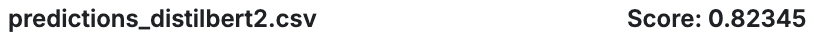

In [33]:
import os
os.makedirs('/kaggle/working/models', exist_ok=True)

In [34]:
model_path = '/kaggle/working/models/model_distilbert.pth'
torch.save(model.state_dict(), model_path)